<a href="https://colab.research.google.com/github/simonetome/ApplieAI-Biomedicine-Masciulli-Pietrobon-Tome/blob/main/VariablePatchSize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this notebook is to show performances augmenting samples of the imbalanced class with random gaussian noise of zero mean and variance 0.05 as suggested in DOI: 10.1155/2020/3215681

In [ ]:
!pip install heartpy

     |████████████████████████████████| 1.0 MB 5.4 MB/s 


In [ ]:
import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image
import tensorflow as tf 
from tensorflow import keras
import sys
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import heartpy as hp

SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [ ]:
COLAB = 1

if COLAB:
  from google.colab import drive
  drive.mount('/gdrive',force_remount=True)
  dataset_current_folder = os.path.join(os.getcwd(),'../gdrive/MyDrive/training_set.zip')
  dataset_folder = os.path.join(os.getcwd(),'AppliedAI_training_set')
  if not os.path.exists(dataset_folder):
    os.mkdir(dataset_folder)
  with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)
else:
  dataset_current_folder = "training_set.zip" # where the zip is
  dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

  with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
      zip.extractall(dataset_folder)

Mounted at /gdrive


In [ ]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
    label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
    peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
    signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
    if os.path.isfile(label_filepath):
        mat_file = loadmat(label_filepath)
        label = np.asarray(mat_file['labels'])
    if os.path.isfile(peak_filepath):
        mat_file = loadmat(peak_filepath)
        peaks = np.array(mat_file['rpeaks'],dtype=np.int64)
    if os.path.isfile(signal_filepath):
        mat_file = loadmat(signal_filepath)
        signal = np.asarray(mat_file['ecg'] )

    return label, peaks, signal

labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))


In [ ]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols

# transform peaks 
for id in tqdm(df.index.tolist()):
    peaks = df.iloc[id]['peaks']
    p_list = list()
    for p in peaks:
        p_list.append(p[0])
    df.iloc[id]['peaks'] = np.asarray(p_list).astype(np.int64)

df.head()

100%|██████████| 105/105 [00:00<00:00, 572.08it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S102,"[0.105, 0.0, -0.06, -0.085, -0.085, -0.09, -0....","[-0.06, -0.07, -0.11, -0.16, -0.18, -0.18, -0....","[163, 333, 503, 675, 845, 1015, 1187, 1361, 15...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S055,"[0.175, 0.185, 0.185, 0.16, 0.15, 0.14, 0.125,...","[0.59, 0.595, 0.595, 0.595, 0.585, 0.565, 0.54...","[94, 225, 353, 477, 607, 736, 863, 992, 1063, ...",128,"[N, N, N, N, N, N, N, N, S, N, V, N, N, N, N, ..."
2,S059,"[-0.065, -0.055, -0.055, -0.045, -0.035, -0.03...","[-0.055, -0.045, -0.045, -0.045, -0.045, -0.03...","[96, 208, 319, 434, 546, 657, 771, 884, 998, 1...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
3,S087,"[0.06, 0.06, 0.08, 0.095, 0.11, 0.11, 0.12, 0....","[0.1, 0.04, 0.015, 0.015, 0.035, 0.065, 0.08, ...","[29, 123, 219, 311, 407, 503, 591, 687, 783, 8...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S029,"[0.0, 0.225, 0.275, 0.095, -0.27, -0.425, -0.3...","[0.51, 0.72, 0.08, -0.56, -1.135, -0.75, -0.46...","[102, 190, 278, 367, 453, 541, 629, 717, 804, ...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [ ]:
# downsampling signal 
from scipy.signal import resample

ids_128 = df[df['frequencies'] == 128].index.tolist() 
ids_250 = df[df['frequencies'] == 250].index.tolist() 
resampled_len = len(df.iloc[ids_128[0]]['ecg_lead_1'])
sampled_len = len(df.iloc[ids_250[0]]['ecg_lead_1'])


for id in tqdm(ids_250):
    row = df.iloc[id]
    # first lead
    signal = np.asarray(row['ecg_lead_1']).astype(np.float32)
    resampled_1 = resample(signal,resampled_len)
    
    # second lead
    signal = np.asarray(row['ecg_lead_2']).astype(np.float32)
    resampled_2 = resample(signal,resampled_len)
    
    df.iloc[id]['ecg_lead_1'] = resampled_1.tolist()
    df.iloc[id]['ecg_lead_2'] = resampled_2.tolist()
    
    for i,p in enumerate(list(df.iloc[id]['peaks'])):
        df.iloc[id]['peaks'][i] = int(resampled_len * p/sampled_len)

df.head()

100%|██████████| 40/40 [00:14<00:00,  2.71it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S102,"[0.05247736722230911, -0.04736786708235741, -0...","[-0.05107278376817703, -0.11004479974508286, -...","[83, 170, 257, 345, 432, 519, 607, 696, 785, 8...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S055,"[0.175, 0.185, 0.185, 0.16, 0.15, 0.14, 0.125,...","[0.59, 0.595, 0.595, 0.595, 0.585, 0.565, 0.54...","[94, 225, 353, 477, 607, 736, 863, 992, 1063, ...",128,"[N, N, N, N, N, N, N, N, S, N, V, N, N, N, N, ..."
2,S059,"[-0.065, -0.055, -0.055, -0.045, -0.035, -0.03...","[-0.055, -0.045, -0.045, -0.045, -0.045, -0.03...","[96, 208, 319, 434, 546, 657, 771, 884, 998, 1...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
3,S087,"[0.03456635773181915, 0.08404164761304855, 0.1...","[0.05529602989554405, 0.024872291833162308, 0....","[14, 62, 112, 159, 208, 257, 302, 351, 400, 44...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S029,"[0.0, 0.225, 0.275, 0.095, -0.27, -0.425, -0.3...","[0.51, 0.72, 0.08, -0.56, -1.135, -0.75, -0.46...","[102, 190, 278, 367, 453, 541, 629, 717, 804, ...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


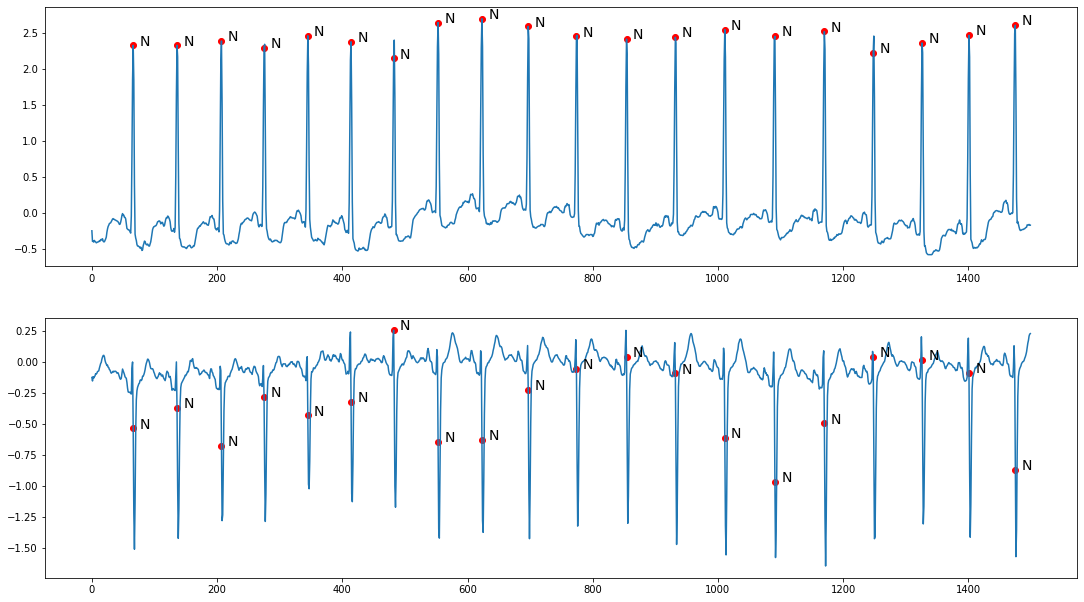

In [ ]:
# plot signal 

def plot_signal(df,id,length):
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
    
    signal = df.iloc[id]
    
    first_lead = signal['ecg_lead_1'][:length]
    second_lead = signal['ecg_lead_2'][:length]
    
    peaks_ = signal['peaks']
    labels_ = signal['labels']
    
    x = list(range(length))
    
    ax1.plot(x,first_lead)
    ax2.plot(x,second_lead)
    
    peaks = list()
    p_amplitudes_first = list()
    p_amplitudes_second = list()
    labels = list()
    
    for i,p in enumerate(peaks_):
        if(p <= length):
            peaks.append(p)
            p_amplitudes_first.append(first_lead[p])
            p_amplitudes_second.append(second_lead[p])
            labels.append(labels_[i])
        else:
            break
            
    ax1.scatter(peaks,p_amplitudes_first,color='red')
    ax2.scatter(peaks,p_amplitudes_second,color='red')
    offset = 10
    
    for i, txt in enumerate(labels):
        ax1.annotate(txt, (peaks[i]+offset, p_amplitudes_first[i]),size = 14)
        ax2.annotate(txt, (peaks[i]+offset, p_amplitudes_second[i]),size = 14)
    
    print(labels)
    plt.show()

plot_signal(df,20,1500)


In [ ]:
# analysis of RR distance RR[1] = distance between peak 1 and peak 0 (not defined for the first peak)
# do that for each signal and check significative differences for each peak label 

signal_ids = df.index.tolist()
RR_dict = {}

for id_ in tqdm(signal_ids):  
  sig_Id = df.iloc[id_]['sigId']
  RR_dict[sig_Id] = {}
  RR_dict[sig_Id]['RR_distances'] = list()
  RR_dict[sig_Id]['S_distances'] = list()
  
  peaks = df.iloc[id_]['peaks']
  labels = df.iloc[id_]['labels']

  for i,p in enumerate(peaks[1:-1]):
    RR_distance = p-peaks[i]
    if(RR_distance < 250): # discard outliers
      RR_dict[sig_Id]['RR_distances'].append(RR_distance)
      if(labels[i+1] == 'S'):
        RR_dict[sig_Id]['S_distances'].append(RR_distance)

  RR_dict[sig_Id]['RR_distances'] = np.asarray(RR_dict[sig_Id]['RR_distances'])
  RR_dict[sig_Id]['S_distances'] = np.asarray(RR_dict[sig_Id]['S_distances'])

  RR_dict[sig_Id]['Avg_RR_distance'] = RR_dict[sig_Id]['RR_distances'].mean()
  RR_dict[sig_Id]['AVG_S_distance'] = RR_dict[sig_Id]['S_distances'].mean()


RR_df = pd.DataFrame.from_dict(RR_dict,orient="index")
RR_df.tail()

100%|██████████| 105/105 [00:00<00:00, 224.92it/s]


,RR_distances,S_distances,Avg_RR_distance,AVG_S_distance
S057,"[50, 106, 79, 79, 80, 80, 80, 79, 80, 79, 82, ...","[57, 61, 75, 72, 74, 54, 52, 61, 48, 45, 45, 6...",85.101626,56.333333
S012,"[121, 98, 126, 95, 129, 94, 130, 89, 135, 91, ...","[98, 95, 94, 89, 89, 86, 91, 70, 59, 96, 71, 7...",101.808050,82.917197
S037,"[82, 81, 81, 81, 82, 82, 83, 83, 83, 83, 84, 8...","[70, 50, 46, 66, 62, 63, 70, 47, 49, 59, 55, 8...",79.910795,60.037736
S050,"[79, 79, 77, 77, 77, 77, 79, 78, 78, 78, 77, 7...","[61, 64, 56, 65, 62, 58, 68, 59, 61, 63, 64, 6...",76.218802,62.800000
S026,"[98, 99, 99, 96, 98, 99, 96, 97, 96, 97, 97, 9...","[58, 48, 46, 46, 44, 49, 48, 54, 60, 67, 62, 5...",96.564597,56.227273


In [ ]:
# S106 has no S? 

row = df[df['sigId'] == 'S106']
labels = row['labels'].values[0]

print(np.any(labels == 'N'))
print(np.any(labels == 'V'))
print(np.any(labels == 'S'))

True
False
False


In [ ]:
max_RR = max(RR_df['Avg_RR_distance'].values)
min_RR = min(RR_df['Avg_RR_distance'].values)
max_S = max(RR_df['AVG_S_distance'].values)
min_S = min(RR_df['AVG_S_distance'].values)

print(max_RR)
print(min_RR)

print(max_S)
print(min_S)

137.8723786698622
54.11278195488722
107.93333333333334
37.233333333333334


100%|██████████| 105/105 [00:04<00:00, 21.03it/s]


['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


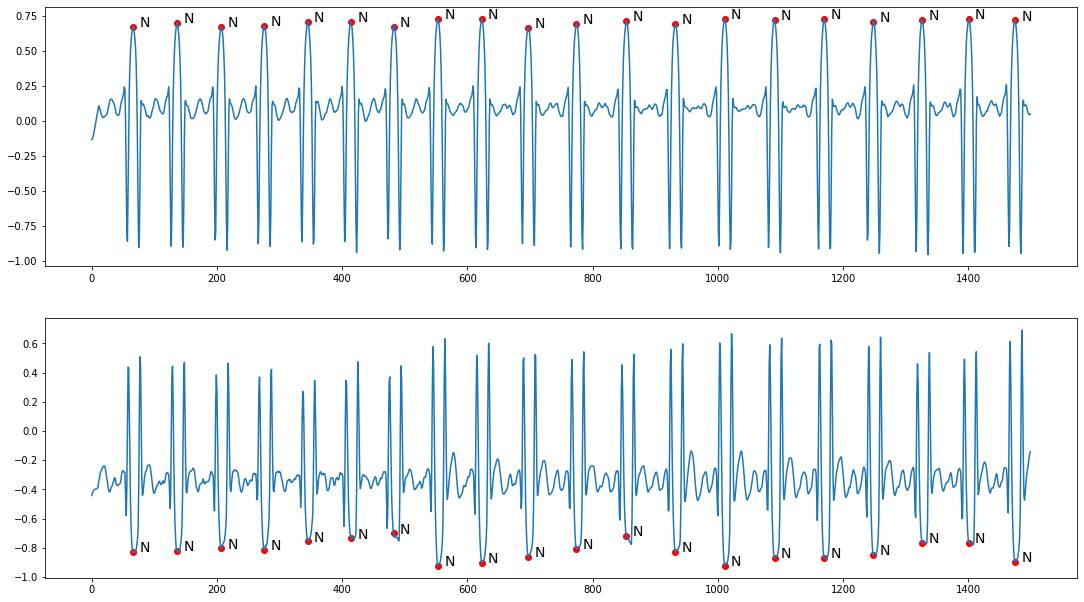

In [ ]:
# center signals and remove baseline 

PREPROCESSING = 1

ids = df['sigId'].index

if PREPROCESSING:
  for id in tqdm(ids):
      row = df.iloc[id]
      
      first_sig = np.array(row['ecg_lead_1'])
      second_sig = np.array(row['ecg_lead_2'])
      
      first_sig = hp.remove_baseline_wander(first_sig, 128,cutoff=0.05)
      first_sig = hp.smooth_signal(first_sig, 128, window_length=21, polyorder=3)
      second_sig = hp.remove_baseline_wander(second_sig, 128,cutoff=0.05)
      second_sig = hp.smooth_signal(second_sig, 128, window_length=21, polyorder=3)
      
      first_sig = np.asarray(first_sig)
      second_sig = np.asarray(second_sig)

      first_sig = first_sig - first_sig.mean()
      second_sig = second_sig - second_sig.mean()

      first_sig = hp.scale_data(first_sig, lower=-1, upper=1)
      second_sig = hp.scale_data(second_sig, lower=-1, upper=1)

      df.iloc[id]['ecg_lead_1'] = first_sig
      df.iloc[id]['ecg_lead_2'] = second_sig

plot_signal(df,20,1500)


In [ ]:
classes = np.array(["N","S","V"])

max_patch_length = 230


def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)

def create_patch_dataset(df):
    
    dataset_dict = {}
    
    ids = df['sigId']


    for id in tqdm(ids):
        row =  df[df['sigId'] == id]
        sigId = row['sigId'].values[0]
        peaks = row['peaks'].values[0]
        first_lead_signal = row['ecg_lead_1'].values[0]
        second_lead_signal = row['ecg_lead_2'].values[0]
        labels = row['labels'].values[0]
        
        avgRR = RR_df.loc[sigId]['Avg_RR_distance']


        left_offset = int(avgRR * 0.4)

        for i,peak in enumerate(peaks):
            index_ = str(str(id) +'_' + str(i))
            dataset_dict[index_] = {}

            dataset_dict[index_]["first_lead"] = list()
            dataset_dict[index_]["second_lead"] = list()

            heartbeat_instance_1 = [0.] * max_patch_length 
            heartbeat_instance_2 = [0.] * max_patch_length 

            size = list(range( int(peak-avgRR/2-left_offset), int(peak+avgRR/2)))
            idx = int(max_patch_length/2 - avgRR/2 - left_offset)

            for s in size:
              if(s < 0 or s >= resampled_len):   # padding with 0
                first_sample = 0.
                second_sample = 0.
              else:
                first_sample = first_lead_signal[s]
                second_sample = second_lead_signal[s]

              heartbeat_instance_1[idx] = first_sample
              heartbeat_instance_2[idx] = second_sample

              idx += 1

        
            dataset_dict[index_]["first_lead"] = np.asarray(heartbeat_instance_1[:])
            dataset_dict[index_]["second_lead"] = np.asarray(heartbeat_instance_2[:])

            dataset_dict[index_]["stringLabel"] = labels[i]
            dataset_dict[index_]["label"] = convert_to_one_hot(labels[i])

    dataset_df = pd.DataFrame.from_dict(dataset_dict,orient='index')
    return dataset_df

In [ ]:
validation_percentage = 0.2
training_df, validation_df = train_test_split(df,test_size = validation_percentage,random_state=SEED)

In [ ]:
training_patches_df = create_patch_dataset(training_df)
validation_patches_df = create_patch_dataset(validation_df)

100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


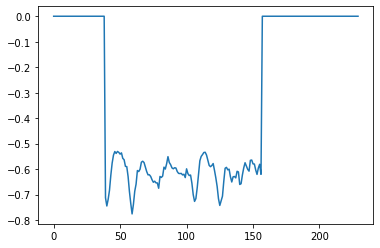

In [ ]:
id_N = training_patches_df[training_patches_df['stringLabel'] == 'N'].index.tolist()
id_S = training_patches_df[training_patches_df['stringLabel'] == 'S'].index.tolist()
id_V = training_patches_df[training_patches_df['stringLabel'] == 'V'].index.tolist()

def plot_patch(id):
  fig,ax = plt.subplots()
  y = training_patches_df.loc[id]['first_lead']
  x = list(range(len(y)))
  ax.plot(x,y)
  plt.show()

plot_patch(id_S[6000])

In [ ]:
# Drop some N samples 
augmenting_coefficient = 2

num_n = len(training_patches_df[(training_patches_df['stringLabel']=='N')])
num_s = len(training_patches_df[(training_patches_df['stringLabel']=='S')])
num_v = len(training_patches_df[(training_patches_df['stringLabel']=='V')])

to_drop = num_n - (max(num_s,num_v))

ids_n = training_patches_df[training_patches_df['stringLabel'] == 'N'].index.tolist()
random.shuffle(ids_n)

ids_to_drop = ids_n[:to_drop]

training_patches_df = training_patches_df.drop(ids_to_drop)


Data augmentation

In [ ]:
training_patches_df.head()
ids_ = training_patches_df.index.tolist()
print(type(ids_[0]))
print(ids_[0])

<class 'str'>
S006_6


In [ ]:

    
s_to_augment = num_s * 0
v_to_augment = num_v * 0

ids_s = training_patches_df[training_patches_df['stringLabel'] == 'S'].index.tolist()
ids_v = training_patches_df[training_patches_df['stringLabel'] == 'V'].index.tolist()
    


In [ ]:
print(ids_s[0])
print(training_patches_df.loc[ids_s[0]])
print(training_patches_df.loc[(random.choice(ids_v))])

ids_s_to_augment = list()
ids_v_to_augment = list()

for i in range(s_to_augment):
    ids_s_to_augment.append(random.choice(ids_s))

for i in range(v_to_augment):
    ids_v_to_augment.append(random.choice(ids_v))

mean, std_deviation = 0, 0.005
print(type(np.random.normal(mean,std_deviation)))

S006_122
first_lead     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
second_lead    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
stringLabel                                                    S
label                                            [0.0, 1.0, 0.0]
Name: S006_122, dtype: object
first_lead     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
second_lead    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
stringLabel                                                    V
label                                            [0.0, 0.0, 1.0]
Name: S037_677, dtype: object
<class 'float'>


In [ ]:
i = 0
to_augment = list(ids_s_to_augment+ids_v_to_augment)
for id in tqdm(to_augment):
    
    to_concat = {}
    to_concat[str(i)] = {}    
    to_concat[str(i)]['first_lead'] = list()
    to_concat[str(i)]['second_lead'] = list()
    to_concat[str(i)]['stringLabel'] = training_patches_df.loc[id]['stringLabel']
    to_concat[str(i)]['label'] = training_patches_df.loc[id]['label']

    first_signal = training_patches_df.loc[id]['first_lead']
    second_signal = training_patches_df.loc[id]['second_lead']

    for y in first_signal:
        noise = np.random.normal(mean,std_deviation)
        to_concat[str(i)]['first_lead'].append(y+noise)

    for y in second_signal:
        noise = np.random.normal(mean,std_deviation)
        to_concat[str(i)]['second_lead'].append(y+noise)

    to_concat_df = pd.DataFrame.from_dict(to_concat,orient="index")
    training_patches_df = training_patches_df.append(to_concat_df)
    i += 1



0it [00:00, ?it/s]


N: 7334
V: 6558
S: 7334


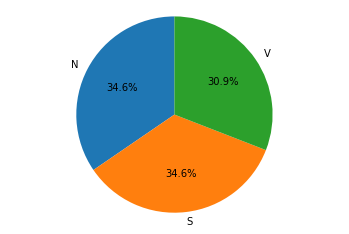

In [ ]:
balanced_df = training_patches_df

ids_n = balanced_df.index[balanced_df['stringLabel'] == 'N'].tolist() 
ids_v = balanced_df.index[balanced_df['stringLabel'] == 'V'].tolist() 
ids_s = balanced_df.index[balanced_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()


In [ ]:
def create_input(df):
    
    x = list()
    y = list()
    
    for id in tqdm(df.index.tolist()):
        row = df.loc[id]
        x.append(np.transpose(np.asarray([row['first_lead'],row['second_lead']]).astype(np.float32)))
        y.append(row['label'])

    x = np.asarray(x).astype(np.float32)
    y = np.asarray(y).astype(np.float32)
    
    return x,y

In [ ]:
training_patches_df.head()

,first_lead,second_lead,stringLabel,label
S006_6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",V,"[0.0, 0.0, 1.0]"
S006_8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",V,"[0.0, 0.0, 1.0]"
S006_10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",V,"[0.0, 0.0, 1.0]"
S006_12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",V,"[0.0, 0.0, 1.0]"
S006_14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",V,"[0.0, 0.0, 1.0]"


In [ ]:
x_train,y_train = create_input(training_patches_df)
x_valid,y_valid = create_input(validation_patches_df)

100%|██████████| 49048/49048 [00:10<00:00, 4835.63it/s]


In [ ]:
import seaborn as sns
from keras.utils.vis_utils import plot_model
from math import gcd
from sklearn.utils.class_weight import compute_class_weight

batch_size = 128


def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = keras.layers.Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = keras.layers.BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = keras.layers.Activation('relu')(norm1)  
    dropout = keras.layers.Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = keras.layers.Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = keras.layers.Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = keras.layers.Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = keras.layers.Activation('relu')(norm1)    
    dropout = keras.layers.Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = keras.layers.Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = keras.layers.Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = keras.layers.Activation('relu')(sum)
    
    return relu2 

#N= number of blocks in resnet, ch = different channels, win_len = common lenght for ecg signals, classes=..
def resnet(N=8, custom_loss = None): 
    ecg_input = keras.layers.Input(shape=(max_patch_length,2), name='ecg_signal') 

    ResNet = keras.layers.Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = keras.layers.BatchNormalization()(ResNet)
    ResNet = keras.layers.Activation('relu')(ResNet)
    ResNet = keras.layers.MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = keras.layers.GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    #Not necessary?
    #ResNet = Flatten()(ResNet) 

    # Sigmoid activation function on the last layer to retrieve all the combination, instead of softmax
    ResNet = keras.layers.Dense(3, activation='softmax',  name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs: 
    model = tf.keras.Model(inputs=[ecg_input],outputs=ResNet)

    # summarize layers
    print(model.summary())
    # plot graph
    #plot_model(model, to_file='convolutional_neural_network.png')
    return model

nn= resnet()

callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,
    mode="auto",
    restore_best_weights=False,
)


learning_rate = 1e-5
nn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['Precision', 'Recall'],
    
)
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
                                            class_weight = 'balanced', 
                                            classes = np.unique(y_integers), 
                                            y = y_integers 
                                        )
d_class_weights = dict(enumerate(class_weights))

history = nn.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 100,
    shuffle = True,
    callbacks=[callback],
    #class_weight = d_class_weights
).history

#validation_data=(X_val_filt, y_val),

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ecg_signal (InputLayer)        [(None, 230, 2)]     0           []                               
                                                                                                  
 conv1d_20 (Conv1D)             (None, 230, 64)      1984        ['ecg_signal[0][0]']             
                                                                                                  
 batch_normalization_20 (BatchN  (None, 230, 64)     256         ['conv1d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 230, 64)      0           ['batch_normalization_20[0]

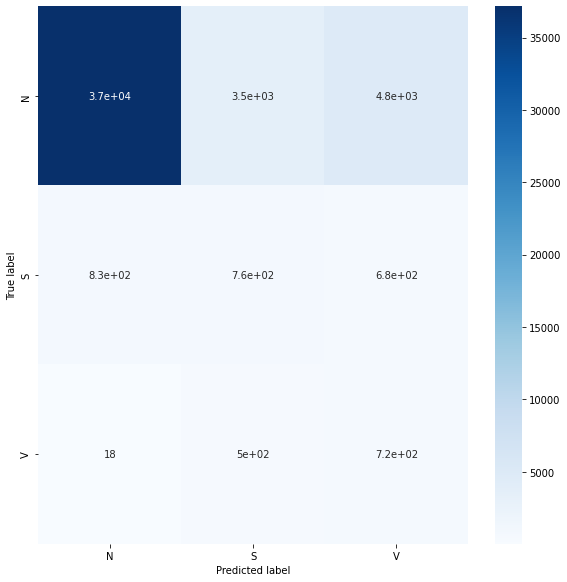

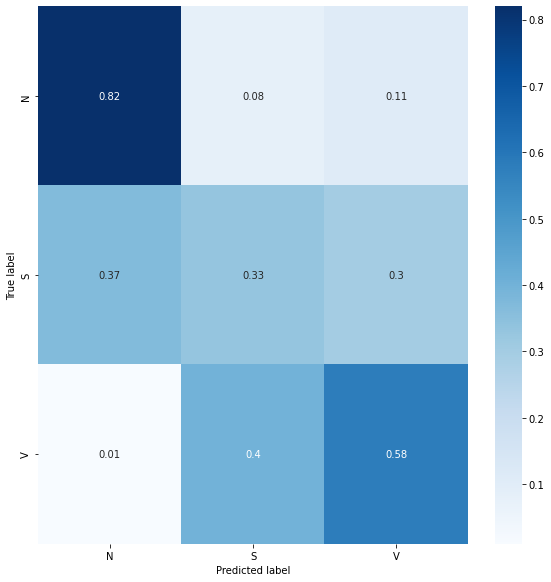

In [ ]:

# take also old samples to assess performances 
def plot_confusion_matrix(y_true, y_pred,normalized):
    """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
    """
    con_mat = tf.math.confusion_matrix(labels=y_val_classes, predictions=y_pred).numpy()
    if (normalized):
      con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
      con_mat_df = pd.DataFrame(con_mat_norm,
                      index = classes, 
                      columns = classes)
    else:
        con_mat_df = pd.DataFrame(con_mat,
                      index = classes, 
                      columns = classes)
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return con_mat


print("Making predictions ...",end="\r")

y_pred= nn.predict(x_valid)

y_pred=np.argmax(y_pred,axis=1)
y_val_classes=np.argmax(y_valid, axis=1)

conf = plot_confusion_matrix(y_val_classes, y_pred,0)
conf = plot_confusion_matrix(y_val_classes, y_pred,1)